<a href="https://colab.research.google.com/github/hsnawn/Fire-and-Smoke-Detection-using-Google-Colab/blob/main/Fire_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



1.   List item

1.   List item
2.   List item


2.   List item



# FIre and Smoke Detection with Keras and Deep Leaning
## 2017-FYP-7




In [87]:
import sys

In [88]:
#!{sys.executable} -m pip uninstall tensorflow -q

In [89]:
#!{sys.executable} -m pip install tensorflow -q

##Import Libraries and Neural Network Model Class

In [90]:
import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())

2.12.0



In [91]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import SeparableConv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense

class FireDetectionNet:
	@staticmethod
	def build(width, height, depth, classes):
		# initialize the model along with the input shape to be
		# "channels last" and the channels dimension itself
		model = Sequential()
		inputShape = (height, width, depth)
		chanDim = -1

		# CONV => RELU => POOL
		model.add(SeparableConv2D(16, (7, 7), padding="same",
			input_shape=inputShape))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# CONV => RELU => POOL
		model.add(SeparableConv2D(32, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# (CONV => RELU) * 2 => POOL
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(SeparableConv2D(64, (3, 3), padding="same"))
		model.add(Activation("relu"))
		model.add(BatchNormalization(axis=chanDim))
		model.add(MaxPooling2D(pool_size=(2, 2)))

		# first set of FC => RELU layers
		model.add(Flatten())
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# second set of FC => RELU layers
		model.add(Dense(128))
		model.add(Activation("relu"))
		model.add(BatchNormalization())
		model.add(Dropout(0.5))

		# softmax classifier
		model.add(Dense(classes))
		model.add(Activation("softmax"))

		# return the constructed network architecture
		return model

# Mount Google Drive with Google Colab


In [92]:
#from google.colab import drive
#drive.mount('/content/drive')

##Import Data from Google Drive

In [93]:

# initialize the path to the fire and non-fire dataset directories
try:
    FIRE_PATH = './FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/fire'
except:
    FIRE_PATH = '/content/drive/My Drive/Fire and Smoke DATASET/Fire Dataset'
try: 
    NON_FIRE_PATH = './FOREST_FIRE_SMOKE_AND_NON_FIRE_DATASET/test/non fire'
except:
    NON_FIRE_PATH = '/content/drive/My Drive/Fire and Smoke DATASET/Non-Fire Dataset'    

# initialize the class labels in the dataset
CLASSES = ["Non-Fire", "Fire"]

# define the size of the training and testing split
TRAIN_SPLIT = 0.70
TEST_SPLIT = 0.30

# define the initial learning rate, batch size, and number of epochs
INIT_LR = 1e-3
BATCH_SIZE = 32
NUM_EPOCHS = 30

# set the path to the serialized model after training
####MODEL_PATH = os.path.sep.join(["output", "fire_detection.model"])

# define the path to the output learning rate finder plot and
# training history plot
####LRFIND_PLOT_PATH = os.path.sep.join(["output", "lrfind_plot.png"])
####TRAINING_PLOT_PATH = os.path.sep.join(["output", "training_plot.png"])

# define the path to the output directory that will store our final
# output with labels/annotations along with the number of iamges to
# sample
####OUTPUT_IMAGE_PATH = os.path.sep.join(["output", "examples"])
SAMPLE_SIZE = 50

In [94]:
#!{sys.executable} -m pip install imutils -q
#!{sys.executable} -m pip install opencv-python opencv-contrib-python -q

In [95]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys

def load_dataset(datasetPath):
	# grab the paths to all images in our dataset directory, then
	# initialize our lists of images
	imagePaths = list(paths.list_images(datasetPath))
	data = []

	# loop over the image paths
	for imagePath in imagePaths:
		# load the image and resize it to be a fixed 128x128 pixels,
		# ignoring aspect ratio
		image = cv2.imread(imagePath)
		image = cv2.resize(image, (128, 128))

		# add the image to the data lists
		data.append(image)

	# return the data list as a NumPy array
	return np.array(data, dtype="float32")

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-f", "--lr-find", type=int, default=0,
#	help="whether or not to find optimal learning rate")
#args = vars(ap.parse_args())

# load the fire and non-fire images
print("[INFO] loading data...")
fireData = load_dataset( FIRE_PATH)
nonFireData = load_dataset( NON_FIRE_PATH)
print("[INFO] Completed")

[INFO] loading data...
[INFO] Completed


##Preprocessing and Exploring Dataset

In [96]:
print(fireData.shape)
print(nonFireData.shape)

(3500, 128, 128, 3)
(3500, 128, 128, 3)


In [97]:
# construct the class labels for the data
fireLabels = np.ones((fireData.shape[0],))
nonFireLabels = np.zeros((nonFireData.shape[0],))
# stack the fire data with the non-fire data, then scale the data
# to the range [0, 1]
data = np.vstack([fireData, nonFireData])
labels = np.hstack([fireLabels, nonFireLabels])


In [98]:
data /= 255
# perform one-hot encoding on the labels and account for skew in the
# labeled data
labels = to_categorical(labels, num_classes=2)
classTotals = labels.sum(axis=0)
classWeight = classTotals.max() / classTotals

In [99]:
print(data.shape)
print(labels.shape)
print(labels[1:])
print(classTotals)

(7000, 128, 128, 3)
(7000, 2)
[[0. 1.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [1. 0.]
 [1. 0.]]
[3500. 3500.]


In [100]:
# construct the training and testing split
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size= TEST_SPLIT, random_state=42)

In [101]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(4900, 128, 128, 3)
(4900, 2)
(2100, 128, 128, 3)
(2100, 2)


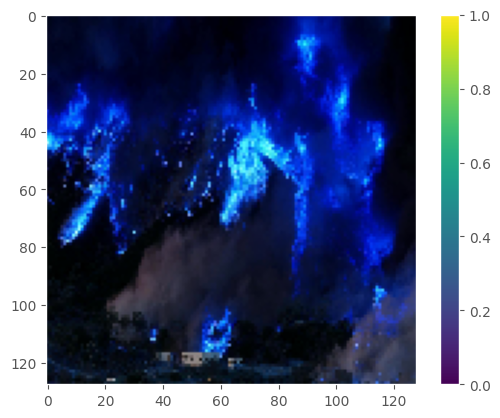

In [102]:
%matplotlib inline
plt.figure()
plt.imshow(trainX[1])
plt.colorbar()
plt.grid(False)
plt.show()

In [103]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(trainX[i], cmap=plt.cm.binary)
    if trainY[i][0] == 1:
      plt.xlabel("Non-Fire")
    else:
      plt.xlabel("Fire")

plt.show()

##Training Model

In [104]:
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
import os
import shutil

In [105]:
%load_ext tensorboard
# delete the previous logs directory
log_dir = '/logs'
if os.path.exists(log_dir):
    shutil.rmtree(log_dir)

# create the directory for tensorboard logs
if not os.path.exists(log_dir):
    os.makedirs(log_dir)
#%tensorboard --logdir logs/
tensorboard = TensorBoard(log_dir=log_dir, histogram_freq=1)
# initialize the training data augmentation object
aug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

# initialize the optimizer and model
print("[INFO] compiling model...")
#opt = SGD(lr= INIT_LR, momentum=0.9,
#	decay= INIT_LR /  NUM_EPOCHS)
#opt = keras.optimizers.Adam(lr=INIT_LR)


opt = keras.optimizers.Adam(learning_rate=INIT_LR)
#model = FireDetectionNet.build(width=128, height=128, depth=3,
#	classes=2)
#model.compile(loss="binary_crossentropy", optimizer=opt,
#	metrics=["accuracy"])

# Создание модели
model = Sequential()

# Добавление свёрточного слоя
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))

#Батч-нормализация
model.add(BatchNormalization())

# Добавление слоя пулинга
model.add(MaxPooling2D((2, 2)))

# Добавление ещё одного свёрточного слоя
model.add(Conv2D(64, (3, 3), activation='relu'))

# Добавление ещё одного слоя пулинга
model.add(MaxPooling2D((2, 2)))

# Добавление слоя flatten
model.add(Flatten())

# Добавление полностью связанного слоя
model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
#model.add(Dropout(0.2))
# Добавление выходного слоя
model.add(Dense(2, activation='softmax'))

# Компилирование модели
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
# Вывод структуры модели
model.summary()



# check to see if we are attempting to find an optimal learning rate
# before training for the full number of epochs

# calculate the class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(trainY.argmax(axis=1)), y=trainY.argmax(axis=1))
class_weight_dict = dict(enumerate(class_weights))

# train the network
print("[INFO] training network...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    class_weight=class_weight_dict,
    verbose=1,
    callbacks=[tensorboard]
)

# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size= BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names= CLASSES))


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
[INFO] compiling model...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_55 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 30, 64)       0         
 g2

In [106]:

MODEL_PATH = 'MODEL'
if os.path.exists(MODEL_PATH):
    shutil.rmtree(MODEL_PATH)
os.makedirs(MODEL_PATH)
print("[INFO] serializing network to '{}'...".format( MODEL_PATH))
model.save(os.path.join(MODEL_PATH, 'model.h5'))

[INFO] serializing network to 'MODEL'...


In [107]:
%matplotlib inline
#import matplotlib.pyplot as plt
#print(H.history["loss"])
#N = np.arange(0,  NUM_EPOCHS)
#print(N)
#plt.plot(N,H.history["loss"])
import matplotlib.pyplot as plt
import numpy as np

N = np.arange(0,  NUM_EPOCHS)
plt.style.use("ggplot")
fig = plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [108]:
fig.savefig('my_figure.png')

##Exploring Predictions

In [109]:
print(predictions.shape)
print(predictions[:1])

(2100, 2)
[[9.999969e-01 3.079229e-06]]


In [110]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(testX[i], cmap=plt.cm.binary)
    if testY[i][0] == 1:
      if predictions[i][0] > 0.5:
        plt.xlabel("Non-Fire", color='green')
      else:
        plt.xlabel("Non-Fire", color='red')
    else:
      if predictions[i][1] > 0.5:
        plt.xlabel("Fire", color='green')
      else:
        plt.xlabel("Fire", color='red')

plt.show()

In [111]:
#MODEL_PATH = '/content/drive/My Drive/firedata'
MODEL_PATH_2 = 'MODEL_2'
if os.path.exists(MODEL_PATH_2):
    shutil.rmtree(MODEL_PATH_2)
os.makedirs(MODEL_PATH_2)
model.save(os.path.join(MODEL_PATH_2, 'model.h5'))

In [112]:
model.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 batch_normalization_55 (Bat  (None, 126, 126, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 63, 63, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 30, 30, 64)       0         
 g2D)                                                            
                                                     

#Save model and architecture to single file


In [113]:
# save model and architecture to single file

#model.save("/content/drive/My Drive/Colab Notebooks/2017ee80.h5")
FIN = os.path.join(os.getcwd(), 'FIN')
if os.path.exists(FIN):
    shutil.rmtree(FIN)
os.makedirs(FIN)
model.save(os.path.join(FIN, 'model.h5'))
print("Saved model to drive")

Saved model to drive


# Thank you